# Assignment 2
I'll start by including some of the libraries I'll be needing throughout this

In [1]:
using Roots,QuantEcon,NLsolve,Parameters,Plots,DataFrames,LinearAlgebra,StatsPlots

#### Problem 1
Taking first order conditions of the social planners problem when $\phi=0$ and imposing the steady state
gives the following three equations
$$
\begin{align}
1&=\beta[1-\delta+\alpha k^{\alpha-1}n^{1-\alpha}]\\
\chi n^\gamma &=(1-\alpha)k^\alpha n^{-\alpha}\frac1{c}\\
c&=Ak^\alpha n^{1-\alpha}-\delta k
\end{align}
$$
Our calibration sets $\beta=0.99$, $\gamma=2$ and $\alpha=0.3$ then targets $\frac{\bar i}{\bar y}=0.16$ and $\bar n=0.3$.
We can acheive this by noting
$$
0.16 =\frac{\bar i}{\bar y}=\frac{\delta\bar k}{\bar k^\alpha \bar n^{1-\alpha}}=\frac{\delta}{\bar k^{\alpha-1}\bar n^{1-\alpha}}
$$
Plugging this into equation 1 we find that
$$
\delta = \frac{\frac1\beta -1}{\frac{\alpha}{0.16}-1}
$$
and
$$
\bar k = \left(\frac{\delta}{0.16\bar n^{1-\alpha}}\right)^\frac{1}{\alpha-1}.
$$
Finally we have that 
$$
\bar c = A\bar k^\alpha\bar n^{1-\alpha}-\delta\bar k
$$
and
$$
\chi = \bar n^{-\gamma}(1-\alpha)k^\alpha n^{-\alpha}\frac1{c}
$$
This is implemented in the code bellow `RBCmodelNS()` constructs and instance of `RBCmodelNS` using this procedure 
to calibrate the parameters

In [2]:
@with_kw mutable struct RBCmodelNS
    β::Float64
    γ::Float64 
    α::Float64 
    χ::Float64 
    δ::Float64 
    ϕ::Float64

    #steady state
    n̄::Float64 
    ī::Float64
    k̄::Float64
    c̄::Float64

    #objects for Bellman equation
    kgrid::Vector{Float64} = zeros(0)
    U::Matrix{Float64} = zeros(0,0)
    n::Matrix{Float64} = zeros(0,0)
end

"""
    RBCmodelNS()

Constructs RBCmodelNS based on calibration and stores steady state
"""
function RBCmodelNS()
    β = 0.98
    α = 0.3
    γ = 2.
    #first compute steady state
    n̄ = 0.3
    δ = (1/β-1)/(α/0.16 - 1)
    k̄ = (δ/0.16*n̄^(α-1))^(1/(α-1))
    c̄ = k̄^α*n̄^(1-α)-δ*k̄
    χ = n̄^(-γ)*(1-α)*k̄^α*n̄^(-α)/c̄
    ī = δ*k̄
    return RBCmodelNS(β=β,α=α,χ=χ,γ=γ,δ=δ,ϕ=0.,n̄=n̄,ī=ī,k̄=k̄,c̄=c̄)
end;
model = RBCmodelNS()
println(model.χ)
println(model.δ)

30.8641975308642
0.02332361516034988


#### Problem 2
We'll approach this problem by solving the system of equations for the path ${k_t}_{t=1}^T$ where
it is assumed we have converged to the steady state after $T$ periods.  We'll solve jointly for the
path of investment and labor $\{i_t,n_t\}_{t=1}^T$ (this latter will allow us to easily implement capital adjustment costs).
Given this path the following equations must be satisfied
$$
\begin{align}
    \frac{1}{c_t} &= \beta R_{t+1}\frac{1}{c_{t+1}}\\
    \chi n_t^\gamma &= \frac{1}{c_t}(1-\alpha)k_t^\alpha n_t^{-\alpha}
\end{align}
$$
where $R_t = 1-\delta+\alpha k_t^{\alpha-1} n_t^{1-\alpha}$.  I've implemented this in the following code

In [3]:
"""
    path_residuals(model::RBCmodelNS,k0::Float64,ihpath)

compute residuals given a path of i and n
"""
function path_residuals!(model::RBCmodelNS,k0::Float64,res,inpath,T)
    @unpack α,β,δ,γ,χ,k̄,n̄,c̄ = model
    ipath,npath = inpath[1:T],inpath[T+1:end]
    k = zeros(T+2)
    k[1] = k0
    for t in 1:T
        k[t+1] = (1-δ)*k[t] + ipath[t] 
    end
    k[T+2] = k̄
    n = [npath;n̄]
    #compute path of c given guess of $k$
    c = [k[t]^α*n[t]^(1-α) + (1-δ)*k[t] - k[t+1] for t in 1:T+1]
    u_c = @. 1/c
    u_n = @. χ*n^γ
    F_n = @. (1-α)*k[1:T+1]^α*n^(-α)
    R = @. 1-δ+α*k[1:T+1]^(α-1)*n^(1-α)

    res[1:T] .= u_c[1:T].-β.*R[2:T+1].*u_c[2:T+1]
    res[T+1:end] .= u_c[1:T].*F_n[1:T].-u_n[1:T]
end;

`path_residuals!` takes a guess of the path of $i_t$ and $n_t$ stacked together and returns
the stacked residuals of the Euler equation and labor leisure choice (this ordering will be important 
later).  We then need to wrap this in a solver to return the solution

In [4]:
"""
    solve_transition(model::RBCmodelNS,k0,T)
    
returns a path of 
"""
function solve_transition(model::RBCmodelNS,k0,T)
    @unpack α,β,δ,k̄,n̄,c̄ = model
    f!(F,x) = path_residuals!(model,k0,F,x,T)
    inpath0 = [model.ī*ones(T);model.n̄*ones(T)]

    res = nlsolve(f!,inpath0)

    if !converged(res)
        error("Could not find root")
    end
    #Now back out aggregates
    inpath = res.zero
    ipath,npath = inpath[1:T],inpath[T+1:end]
    k = zeros(T+2)
    k[1] = k0
    for t in 1:T
        k[t+1] = (1-δ)*k[t] + ipath[t] 
    end
    k[T+2] = k̄
    n = [npath;n̄]
    #compute path of c given guess of $k$
    c = [k[t]^α*n[t]^(1-α) + (1-δ)*k[t] - k[t+1] for t in 1:T+1]
    y = [k[t]^α*n[t]^(1-α) for t in 1:T+1]
    return DataFrame(k=k[1:T],c=c[1:T],n=n[1:T],i=ipath,y=y[1:T])
end;

Here's the path of capital, consumption, hours and investment if capital starts out 
above the steady state

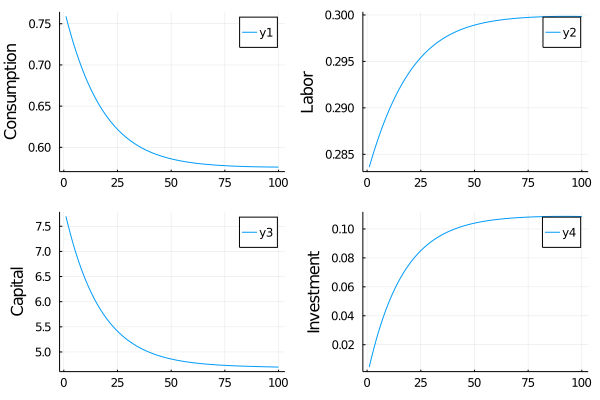

In [5]:
df = solve_transition(model,model.k̄+3,100)
@df df plot(:c,layout=(2,2),subplot=1,ylabel="Consumption")
@df df plot!(:n,subplot=2,ylabel="Labor")
@df df plot!(:k,subplot=3,ylabel="Capital")
@df df plot!(:i,subplot=4,ylabel="Investment")

and below the steady state

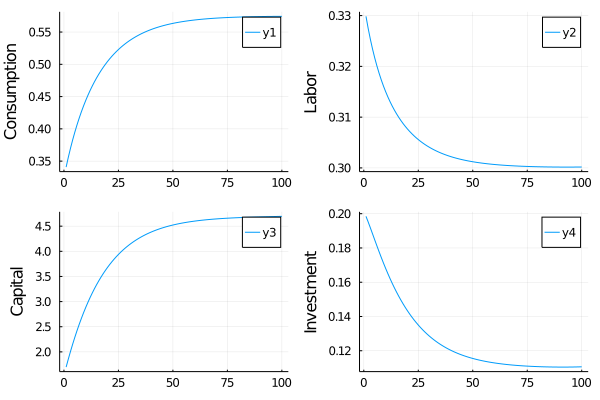

In [6]:
df = solve_transition(model,model.k̄-3,100)
@df df plot(:c,layout=(2,2),subplot=1,ylabel="Consumption")
@df df plot!(:n,subplot=2,ylabel="Labor")
@df df plot!(:k,subplot=3,ylabel="Capital")
@df df plot!(:i,subplot=4,ylabel="Investment")

#### Problem 3
Next we want to solve the bellman equation.  The main difficulty is the addition of labor leisure 
choice.  As this is an intratemporal choice we can pre-solve and store the solution to this problem.
As such for a given $k$ and $k'$ let's define $U(k,k')$ as follows
$$
U(k,k') = \max_{c,h} \log(c)-\chi \frac{n^{1+\gamma}}{1+\gamma}
$$
subject to
$$
c+k' = k^\alpha n^{1-\alpha} +(1-\delta)k
$$
This is the maximal utility that can be acheived if the planner enters with capital $k$ and chooses
capital $k'$.  This problem is summarized by the first order condition
$$
(1-\alpha)k^\alpha n^{-\alpha}\frac{1}{k^\alpha n^{1-\alpha}+(1-\delta)k-k'} = \chi n^\gamma
$$
Constructing a grid over capital

In [7]:
model.kgrid = LinRange(model.k̄*0.8,model.k̄*1.2,400)

400-element LinRange{Float64}:
 3.75803,3.76274,3.76745,3.77216,3.77686,…,5.62291,5.62762,5.63233,5.63704

We fill up the indirect utility matrix (and associated hours policy) in `RBCmodelNS` via the following
function

In [8]:
"""
    construct_indirectU!(model::RBCmodelNS)

Solves for the indirect utility and hours if entering with assets
kgrid[n] and saving kgrid[n′]
"""
function construct_indirectU!(model::RBCmodelNS)
    @unpack α,β,δ,χ,γ,kgrid = model
    N = length(kgrid)
    U = model.U = zeros(N,N)
    n = model.n = zeros(N,N)

    for j in 1:N
        for j′ in 1:N
            i = kgrid[j′] - (1-δ)*kgrid[j]
            k = kgrid[j]

            #minimal labor supply to ensure positive consumption
            nmin = i>0 ? ((i+0.00001)/k^α)^(1/(1-α)) : 0.00001
            f(n) = (1-α)*k^α*n^(-α)/(k^α*n^(1-α)-i) - χ*n^γ #optimal labor leisure choice
            n[j,j′] = brent(f,nmin,100.)
            
            c = k^α*n[j,j′]^(1-α) -i
            U[j,j′] = log(c) - χ*n[j,j′]^(1+γ)/(1+γ)
        end 
    end
end
construct_indirectU!(model);

We can then use this indirect utility function to construct the household bellman equation

In [9]:
"""
    RBCbellmanmap(model::RBCmodelNS,V′)

Iterates on the bellman equation for the standard neoclassical growth model

# Arguments
* `V` Vector of values for each capital level in kgrid
"""
function RBCbellmanmap(model::RBCmodelNS,V′)
    @unpack kgrid,U,n,β = model
    N = length(kgrid)
    V = zeros(N) #new value function
    j_pol = zeros(Int,N) #policy rule for grid points
    k_pol = zeros(N) #policy rule for capital
    n_pol = zeros(N)
    obj = zeros(N)
    for j in 1:N #iterate for each initial capital
        obj .= U[j,:] .+ β.*V′ #note using indirect utiltiy
        V[j],j_pol[j] = findmax(obj) #find optimal value and the choice that gives it
        k_pol[j] = kgrid[j_pol[j]] #record capital policy
        n_pol[j] = n[j,j_pol[j]] #record hours policy
    end
    return V,j_pol,k_pol,n_pol
end;

And the Howard improvement algorithm where we don't update policies

In [10]:
"""
RBCbellmanmap_howard(model::RBCmodelNS,V′,j_pol)

Iterates on the bellman equation for the standard neoclassical growth model

# Arguments
* `V` Vector of values for each capital level in kgrid
* j_pol capital policy
"""
function RBCbellmanmap_howard(model::RBCmodelNS,V′,j_pol)
    @unpack kgrid,U,n,β = model
    N = length(kgrid)
    V = zeros(N) #new value function
    for j in 1:N #iterate for each initial capital
        V[j] = U[j,j_pol[j]] + β*V′[j_pol[j]] #note using indirect utiltiy
    end
    return V
end;

We can then solve the bellman equation in the standard way

In [11]:
"""
    RBCsolve_bellman(model,V0,[,ϵ=1e-8])

Solves the bellman equation by iterating until convergence

# Arguments
* `V0` Initial vector of values for each capital level in kgrid
* `ϵ` Convergence criteria
* H=100 seems to be close to optimal for this problem
"""
function RBCsolve_bellman(model,V0,H=100,ϵ=1e-8)
    diff = 1.
    V,j_pol,k_pol,n_pol = RBCbellmanmap(model,V0)
    while diff > ϵ
        for h in 1:H
            V= RBCbellmanmap_howard(model,V,j_pol)
        end
        V_new,j_pol,k_pol,n_pol = RBCbellmanmap(model,V)
        diff = norm(V_new-V,Inf)
        println(diff)
        V = V_new 
    end
    return V,j_pol,k_pol,n_pol
end
V,j_pol,k_pol,n_pol = RBCsolve_bellman(model,zeros(length(model.kgrid)));

0.41803966615609767
0.13562899188163868
0.054015256117118327
0.04246545573219862
0.04316871081582008
0.025434681188144737
0.00851406567013413
0.002806628150437973
0.0013599191300173175
0.0006316125150220842
0.00025706245072143474
8.936448002572206e-5
3.985779953552537e-5
3.2130355876347494e-5
2.9225997110415847e-5
2.6136341091387294e-5
2.2864567014835302e-5
1.9413790973032974e-5
1.578706528704288e-5
1.1987379615163718e-5
8.017662132431269e-6
3.880780717224752e-6
2.4277647625581267e-6
1.2307404944067457e-6
3.956541050342821e-7
0.0


Finally we can use the constructed policy rules to simulate from an arbitrary initial capital stock

In [12]:
"""
    simulate(model::RBCmodelNS,j_0,T,n_pol,h_pol)

Simulate the path of aggregates for T periods given initial state j_0
"""
function simulate(model::RBCmodelNS,j_0,T,j_pol,n_pol)
    @unpack α,β,δ,χ,γ,kgrid = model
    k = zeros(T+1)
    j = zeros(Int,T+1)
    c,n,y,i = zeros(T),zeros(T),zeros(T),zeros(T)
    j[1] = j_0
    k[1] = kgrid[j_0]
    #no simulate using policies
    for t in 1:T
        j[t+1] = j_pol[j[t]]
        k[t+1] = kgrid[j[t+1]]
        n[t] = n_pol[j[t]]
        y[t] = k[t]^α*n[t]^(1-α)
        i[t] = k[t+1] - (1-δ)*k[t]
        c[t] = y[t] - i[t]
    end

    return DataFrame(k=k[1:T],n=n,c=c,i=i,y=y)
end;

And compare to our solution in part 2.  Here's starting below the steady-state capital

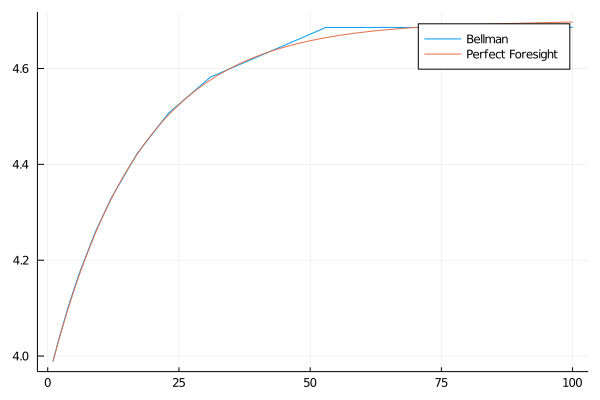

In [13]:
j0=50
df = simulate(model,j0,100,j_pol,n_pol)
df2 = solve_transition(model,model.kgrid[j0],100)
plot(df.k,label="Bellman")
plot!(df2.k,label="Perfect Foresight")

and above

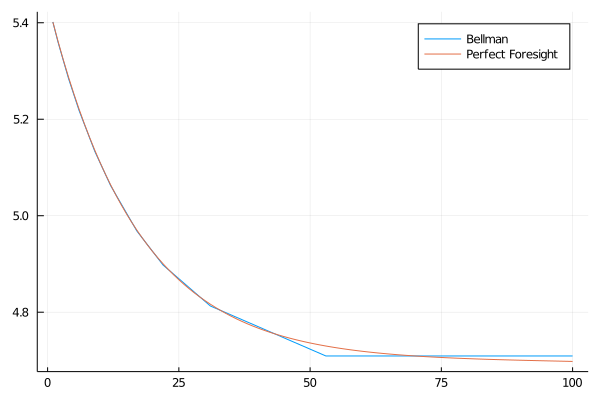

In [14]:
j0=350
df = simulate(model,j0,100,j_pol,n_pol)
df2 = solve_transition(model,model.kgrid[j0],100)
plot(df.k,label="Bellman")
plot!(df2.k,label="Perfect Foresight")

### Problem 4

Adding in $\phi>0$ changes the first order conditions of the planner's problem.  Let $\lambda$ be the multiplier on the budget constraint and $\eta$ be the multiplier on the capital accumulation constraint.  Taking first order conditions implies
\begin{align*}
\frac1c&= \lambda\\
\chi n^\gamma &= \lambda (1-\alpha)\exp(a) k^\alpha n^{-\alpha}\\
\eta &= \lambda\left(1+2\phi(i/k - \delta)\right)\\
\eta &= \beta\mathbb E[V_k(a',k')]
\end{align*}
Finally the envelope condition implies
$$
V_k(a,k) = \lambda\left(\alpha\exp(a)k^{\alpha-1}n^{1-\alpha}-\phi(i/k-\delta)^2 + 2\phi(i/k-\delta)\frac{i}{k}\right) + (1-\delta)\eta
$$

Putting all of these together and defining $q_t \equiv 1+2\phi(i/k-\delta)$ and $r^k_t =\alpha\exp(a)k_t^{\alpha-1}n_t^{1-\alpha}$ one can show that the optimal allocation must satisfy
\begin{align*}
\chi n_t^\gamma &= (1-\alpha)\exp(a)k_t^\alpha n_t^{-\alpha} \\
\frac{1}{c_t}q_tk_{t+1} &= \beta \mathbb E_t\left[ \frac{1}{c_{t+1}}\left(r^k_{t+1}k_{t+1}-\phi(i_{t+1}/k_{t+1}-\delta)^2k_{t+1} - i_{t+1} + q_{t+1}k_{t+2}\right)\right]
\end{align*}
Here $q_t$ represents the marginal value of having a unit of capital in place at time $t$.  In the competitive equilibrium that decentralises the planners problem $q_t$ represet's Tobin's q.  $R^k_{t+1}k_{t+1}-\phi(i_{t+1}/k_{t+1}-\delta)^2k_{t+1} - i_{t+1}$ would represent the period profits of the firm in time $t+1$.  We can update the code to solve for the perfect forsight equilibrium below (note the steady state remains the same because $q_t$ is 1 at the steady state)

In [15]:
"""
    path_residuals_ϕ(model::RBCmodelNS,k0::Float64,ihpath)

compute residuals given a path of i and n.  Allows for ϕ>0
"""
function path_residuals_ϕ!(model::RBCmodelNS,k0::Float64,res,inpath,T)
    @unpack α,β,δ,γ,χ,ϕ,k̄,n̄,c̄,ī = model
    ipath,npath = inpath[1:T],inpath[T+1:end]
    k = zeros(T+2)
    k[1] = k0
    for t in 1:T
        k[t+1] = (1-δ)*k[t] + ipath[t] 
    end
    i = [ipath;ī]
    k[T+2] = k̄
    n = [npath;n̄]
    #compute path of c given guess of $k$
    c = [k[t]^α*n[t]^(1-α) + (1-δ)*k[t] - k[t+1] - ϕ*(i[t]/k[t]-δ)^2*k[t] for t in 1:T+1]
    u_c = @. 1/c
    u_n = @. χ*n^γ
    F_n = @. (1-α)*k[1:T+1]^α*n^(-α)
    F_k = @. α*k[1:T+1]^(α-1)*n^(1-α)
    q   = @. 1+2*ϕ*(i/k[1:T+1]-δ)

    Rk = @. F_k*k[1:T+1] - ϕ*(i/k[1:T+1]-δ)^2*k[1:T+1] - i + q*k[2:T+2] #@. 1-δ+α*k[1:T+1]^(α-1)*n^(1-α)

    res[1:T] .= u_c[1:T].*q[1:T].*k[2:T+1].-β.*Rk[2:T+1].*u_c[2:T+1]
    res[T+1:end] .= u_c[1:T].*F_n[1:T].-u_n[1:T]
end;

In [16]:
"""
    solve_transition_ϕ(model::RBCmodelNS,k0,T)
    
returns a path of 
"""
function solve_transition_ϕ(model::RBCmodelNS,k0,T)
    @unpack α,β,ϕ,δ,k̄,n̄,c̄,ī = model
    f!(F,x) = path_residuals_ϕ!(model,k0,F,x,T)
    inpath0 = [model.ī*ones(T);model.n̄*ones(T)]

    res = nlsolve(f!,inpath0)

    if !converged(res)
        error("Could not find root")
    end
    #Now back out aggregates
    inpath = res.zero
    ipath,npath = inpath[1:T],inpath[T+1:end]
    k = zeros(T+2)
    k[1] = k0
    for t in 1:T
        k[t+1] = (1-δ)*k[t] + ipath[t] 
    end
    k[T+2] = k̄
    n = [npath;n̄]
    i = [ipath;ī]
    #compute path of c given guess of $k$
    c = [k[t]^α*n[t]^(1-α) + (1-δ)*k[t] - k[t+1] - ϕ*(i[t]/k[t]-δ)^2*k[t] for t in 1:T+1]
    y = [k[t]^α*n[t]^(1-α) for t in 1:T+1]
    return DataFrame(k=k[1:T],c=c[1:T],n=n[1:T],i=i[1:T],y=y[1:T])
end;

Plotting the path of capital starting from above the steady state, we see that consumption is initially a lot lower with capital adjustment costs because the planner decreases investment by a much smaller amount.  This leads to a slower decline in the capital stock and higher consumption in the longer term.

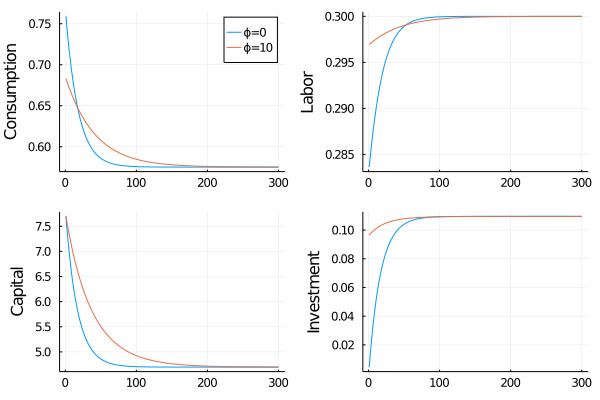

In [17]:
model.ϕ = 10.
df = solve_transition(model,model.k̄+3,300) #solves transition assuming ϕ=0
dfϕ = solve_transition_ϕ(model,model.k̄+3,300)
@df df plot(:c,layout=(2,2),subplot=1,label="ϕ=0",ylabel="Consumption")
@df dfϕ plot!(:c,subplot=1,label="ϕ=10",ylabel="Consumption")
@df df plot!(:n,subplot=2,ylabel="Labor")
@df dfϕ plot!(:n,subplot=2,legend=false)
@df df plot!(:k,subplot=3,ylabel="Capital")
@df dfϕ plot!(:k,subplot=3,legend=false)
@df df plot!(:i,subplot=4,ylabel="Investment")
@df dfϕ plot!(:i,subplot=4,legend=false)

Implementing it in the bellman equation is as easy as changing how we construct $u$ and $n$

In [18]:
"""
    construct_indirectU_ϕ!(model::RBCmodelNS)

Solves for the indirect utility and hours if entering with assets
kgrid[n] and saving kgrid[n′]
"""
function construct_indirectU_ϕ!(model::RBCmodelNS)
    @unpack α,β,δ,χ,γ,ϕ,kgrid = model
    N = length(kgrid)
    U = model.U = zeros(N,N)
    n = model.n = zeros(N,N)

    for j in 1:N
        for j′ in 1:N
            i = kgrid[j′] - (1-δ)*kgrid[j]
            k = kgrid[j]
            ϕcost = ϕ*(i/k-δ)^2*k 
            #minimal labor supply to ensure positive consumption
            nmin = i+ϕcost>0 ? ((i+0.000001+ϕcost)/k^α)^(1/(1-α)) : 0.
            f(n) = (1-α)*k^α*n^(-α)/(k^α*n^(1-α)-i -ϕcost) - χ*n^γ #optimal labor leisure choice
            n[j,j′] = brent(f,nmin,100.)
            
            c = k^α*n[j,j′]^(1-α) -i-ϕcost
            U[j,j′] = log(c) - χ*n[j,j′]^(1+γ)/(1+γ)
        end 
    end
end
construct_indirectU_ϕ!(model);

We then resolve the bellman equation with the new $U$

In [19]:
V,j_pol,k_pol,n_pol = RBCsolve_bellman(model,zeros(length(model.kgrid)));

0.11313304359967447
0.05990861728924557
0.15560539056072997
0.05750155410830615
0.024147766012625027
0.010164412016109736
0.003601531509971778
0.0011298795140888274
0.000614793844938788
0.0003191047467154817
0.00026114964813928054
0.00021381610411452812
0.00018891840618806555
0.00016365522091632556
0.0001555458170017232
0.00015065168101813242
0.0001456083346127457
0.0001404182202477955
0.00013508372973802807


0.00012960720530941217
0.00012399094057968796
0.00011823718148917806
0.00011234812729554733
0.00010632593144066504
0.00010017270253825927
9.389050516261932e-5
8.748136080782842e-5
8.094724869778247e-5
7.429010666015756e-5
6.751183187958532e-5
6.0614281778725854e-5
5.359927475723225e-5
4.646859096624212e-5
3.9223973097080034e-5
3.186712710601114e-5
2.439972290346759e-5
1.6823395149856424e-5
9.139743859520877e-6
1.3503351468102665e-6
4.392047330270543e-7
0.0


and compare to perfect foresight policies for capital

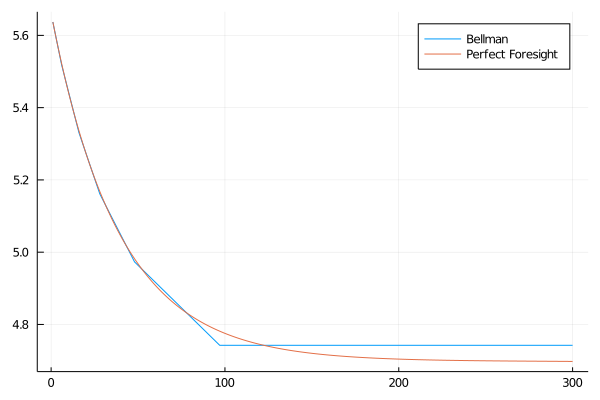

In [20]:
n0= 400
df = simulate(model,n0,300,j_pol,n_pol)
df2 = solve_transition_ϕ(model,model.kgrid[n0],300)
plot(df.k,label="Bellman")
plot!(df2.k,label="Perfect Foresight")

#### Problem 5
Estimating the data on log tfp we find $\rho=0.779$ and $\sigma=0.007$.  We adjust our 
struct and constructor appropriately

In [21]:
@with_kw mutable struct RBCmodel
    β::Float64
    γ::Float64 
    α::Float64 
    χ::Float64 
    δ::Float64 
    ϕ::Float64


    #Stochastic Properties
    A::Vector{Float64}
    P::Matrix{Float64}

    #steady state
    n̄::Float64 
    ī::Float64
    k̄::Float64
    c̄::Float64

    #objects for Bellman equation
    kgrid::Vector{Float64} = zeros(0)
    U::Array{Float64,3} = zeros(0,0,0)
    h::Array{Float64,3} = zeros(0,0,0)
end

"""
    RBCmodel()

Constructs RBCmodelNS based on calibration and stores steady state
"""
function RBCmodel(ρ,σ,N)
    β = 0.98
    α = 0.3
    γ = 2.
    #first compute steady state
    n̄ = 0.3
    δ = (1/β-1)/(α/0.16 - 1)
    k̄ = (δ/0.16*n̄^(α-1))^(1/(α-1))
    c̄ = k̄^α*n̄^(1-α)-δ*k̄
    χ = n̄^(-γ)*(1-α)*k̄^α*n̄^(-α)/c̄
    ī = δ*k̄
    mc = rouwenhorst(N,ρ,σ)
    return RBCmodel(β=β,α=α,χ=χ,γ=γ,δ=δ,ϕ=0.,n̄=n̄,ī=ī,k̄=k̄,c̄=c̄,A=exp.(mc.state_values),P=mc.p)
end;
model = RBCmodel(0.779,0.007,25)

model.kgrid = LinRange(model.k̄*0.8,model.k̄*1.2,400);

#### Problem 6
Next we need to adjust how we construct $U$ to find
$$
U(k,k',s) = \max_{c,n} log(c) - \chi n^{1+\gamma}{1+\gamma}
$$
subject to
$$
c+k' = A(s)k^\alpha h^{1-\alpha} +(1-\delta)k -\phi(i/k-\delta)^2k.
$$ 
Our hours and indirect utility now depends on $s$.

In [22]:
"""
    construct_indirectU!(model::RBCmodel)

Solves for the indirect utility and hours if entering with assets
kgrid[n] and saving kgrid[n′] if the aggregate state is s
"""
function construct_indirectU!(model::RBCmodel)
    @unpack α,β,δ,χ,γ,ϕ,kgrid,A = model
    N = length(kgrid)
    S = length(A)
    U = model.U = zeros(N,N,S)
    n = model.h = zeros(N,N,S)

    for s in 1:S
        for j in 1:N
            for j′ in 1:N
                i = kgrid[j′] - (1-δ)*kgrid[j]
                k = kgrid[j]
                ϕcost = ϕ*(i/k-δ)^2*k 
                #minimal labor supply to ensure positive consumption
                nmin = i+ϕcost>0 ? ((i+0.000001+ϕcost)/(A[s]*k^α))^(1/(1-α)) : 0.
                f(n) = (1-α)*A[s]*k^α*n^(-α)/(A[s]*k^α*n^(1-α)-i -ϕcost) - χ*n^γ #optimal labor leisure choice
                n[j,j′,s] = brent(f,nmin,100.)
                
                c = A[s]*k^α*n[j,j′,s]^(1-α) -i-ϕcost
                U[j,j′,s] = log(c) - χ*n[j,j′,s]^(1+γ)/(1+γ)
            end 
        end
    end
end;
construct_indirectU!(model);

We then need to adjust our functions to solve the bellman equation to allow for 
stochastic productivity

In [23]:
"""
    RBCbellmanmap(model::RBCmodelNS,V′)

Iterates on the bellman equation for the standard neoclassical growth model

# Arguments
* `V` Vector of values for each capital level in kgrid
"""
function RBCbellmanmap(model::RBCmodel,V′)
    @unpack kgrid,U,h,A,P,β = model
    N = length(kgrid)
    S = length(A)
    V = zeros(S,N) #new value function
    j_pol = zeros(Int,S,N) #policy rule for grid points
    k_pol = zeros(S,N) #policy rule for capital
    n_pol = zeros(S,N)
    obj = zeros(N)

    EV′ = P*V′
    for s in 1:S
        for j in 1:N #iterate for each initial capital
            obj .= U[j,:,s] .+ β.*EV′[s,:] #note using indirect utiltiy
            V[s,j],j_pol[s,j] = findmax(obj) #find optimal value and the choice that gives it
            k_pol[s,j] = kgrid[j_pol[s,j]] #record capital policy
            n_pol[s,j] = h[j,j_pol[s,j],s] #record hours policy
        end
    end
    return V,j_pol,k_pol,n_pol
end

"""
    RBCbellmanmap_howard(model::RBCmodelNS,V′)

Iterates on the bellman equation for the standard neoclassical growth model
using the howard improvement algorithm

# Arguments
* `V′` Vector of values for each capital level in kgrid
"""
function RBCbellmanmap_howard(model::RBCmodel,V′,j_pol)
    @unpack kgrid,U,h,P,β = model
    N = length(kgrid)
    S = size(P,1)
    V = zeros(S,N) #new value function
    EV′ = P*V′
    for s in 1:S
        for j in 1:N #iterate for each initial capital
            V[s,j] = U[j,j_pol[s,j],s] + β*EV′[s,j_pol[s,j]] #note using indirect utiltiy
        end
    end
    return V
end
V,j_pol,k_pol,n_pol = RBCsolve_bellman(model,zeros(25,400));

0.44019871765132024
0.13575062181359954


0.05371210401892057
0.0269856446843022


0.024654755141334306
0.01470618404353985


0.004147507918737858
0.0014484855547465258


0.00038206029356757654
5.484100126551539e-5


1.3615378449571836e-5
6.896426825164781e-7


2.766178397450858e-9


Finally we need to adjust the code which simulates the model to allow for 
stochastic productivity.

In [24]:
"""
    simulate(model::RBCmodel,j_0,s_0,T,j_pol,n_pol)

Simulate the path of aggregates for T periods given initial state j_0,s_0
"""
function simulate(model::RBCmodel,j_0,s_0,T,j_pol,n_pol)
    @unpack α,β,δ,ϕ,kgrid,P,A = model
    k = zeros(T+1)
    j = zeros(Int,T+1)
    c,n,y,i = zeros(T),zeros(T),zeros(T),zeros(T)
    s = simulate_indices(MarkovChain(P),T,init=s_0)
    j[1] = j_0
    k[1] = kgrid[j_0]
    #no simulate using policies
    for t in 1:T
        j[t+1] = j_pol[s[t],j[t]]
        k[t+1] = kgrid[j[t+1]]
        n[t] = n_pol[s[t],j[t]]
        y[t] = A[s[t]]*k[t]^α*n[t]^(1-α)
        i[t] = k[t+1] - (1-δ)*k[t]
        c[t] = y[t] - i[t] - ϕ*(i[t]/k[t]-δ)^2*k[t]
    end

    return DataFrame(k=k[1:T],n=n,c=c,i=i,y=y)
end
df = simulate(model,200,13,10000,j_pol,n_pol);

We then drop the first $3000$ periods and compute the standard deviations, autocorrelations,
and cross-correlations of output,consumptions,hours and investment.

In [25]:
using Statistics,StatsBase
df = select!(df,Not(:k)) #drop k
df = last(df,7000) #drop first 3000
describe(df,:std,
                 (x->autocor(x,[1])[1])=>:autocorr,
                 (x->cor(x,df.n))=>:cor_n,
                 (x->cor(x,df.c))=>:cor_c,
                 (x->cor(x,df.i))=>:cor_i,
                 (x->cor(x,df.y))=>:cor_y,
                 )

,variable,std,autocorr,cor_n,cor_c,cor_i,cor_y
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64
1,n,0.00110172,0.708469,1.0,0.237577,0.99403,0.858273
2,c,0.00456667,0.926832,0.237577,1.0,0.341648,0.702345
3,i,0.00779762,0.724057,0.99403,0.341648,1.0,0.908959
4,y,0.0102951,0.815517,0.858273,0.702345,0.908959,1.0


#### Problem 7
Again, implementing $\phi>0$ is as easy as changing a parameter

In [26]:
model.ϕ = 10.
construct_indirectU!(model);

In [27]:
V,n_pol,k_pol,h_pol = RBCsolve_bellman(model,zeros(25,400))

df = simulate(model,200,13,10000,n_pol,h_pol)
df = select!(df,Not(:k)) #drop k
df = last(df,7000) #drop first 3000
describe(df,:std,
                 (x->autocor(x,[1])[1])=>:autocorr,
                 (x->cor(x,df.n))=>:cor_n,
                 (x->cor(x,df.c))=>:cor_c,
                 (x->cor(x,df.i))=>:cor_i,
                 (x->cor(x,df.y))=>:cor_y,
                 )

0.11313448966878781
0.06179473911599587


0.15874632124013743
0.07189682484497695


0.05742748695882938


0.03625232756248664
0.009351255490976484


0.003873616206696795
0.0009973619065775097
0.0003625917885159424


0.0001540163464426314
6.003158796374919e-5


1.2349372440212392e-5
6.473044322774513e-11


,variable,std,autocorr,cor_n,cor_c,cor_i,cor_y
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64
1,n,0.000262476,0.30157,1.0,0.322017,0.892017,0.515474
2,c,0.00610307,0.768695,0.322017,1.0,0.715152,0.977248
3,i,0.0024361,0.574728,0.892017,0.715152,1.0,0.847122
4,y,0.00802822,0.780169,0.515474,0.977248,0.847122,1.0


Capital adjustment costs lead to more volatile consumption and hours but less volatile investment and output.